# **DS-2.2 Baseline modeling pt.2** and **DS-3 Advanced Modeling**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor

import sys

sys.path.append("../")
from scripts.etl import transform_df_types
from scripts.validate import (
    TimeSeriesSplit,
    ModelTrainer,
)
from scripts.modeling import PredictionVisualizer

# Load the train dataset with extracted features

In [3]:
train_df = pd.read_csv("../data/result_train.csv")

train_df = transform_df_types(train_df)
train_df.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,...,item_cnt_month_cat_shop__lag_2,item_cnt_month_cat_shop__lag_3,days,avg_item_price,avg_item_price_lag_1,avg_item_price_lag_2,avg_item_price_lag_3,avg_item_price_lag_4,avg_item_price_lag_5,avg_item_price_lag_6
0,0.0,25.0,16257.0,1.0,148.0,0.0,0.0,Наушники RITMIX RH-124 Black,0.0,PC - Гарнитуры/Наушники,...,0.0,0.0,31.0,148.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,57.0,16255.0,1.0,93.0,1.0,0.0,Наушники PHILIPS SBC HC8680,0.0,PC - Гарнитуры/Наушники,...,0.0,0.0,28.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,38.0,16256.0,1.0,22.4,3.0,0.0,Наушники RITMIX RH-120,0.0,PC - Гарнитуры/Наушники,...,0.0,0.0,30.0,22.4,0.0,0.0,0.0,0.0,0.0,0.0


# Clean train set from unneeded columns

In [4]:
train = train_df.select_dtypes(include=np.number)
y = train["item_cnt_month"]
X = train.drop(
    ["item_cnt_month", "item_price", "revenue", "avg_item_price", "month", "year"],
    axis=1,
    inplace=False,
)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608724 entries, 0 to 1608723
Data columns (total 36 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   date_block_num                  1608724 non-null  float32
 1   shop_id                         1608724 non-null  float32
 2   item_id                         1608724 non-null  float32
 3   item_category_id                1608724 non-null  float32
 4   months_since_last_sale          1608724 non-null  float32
 5   revenue_mean_on_shop_id         1608724 non-null  float32
 6   revenue_lag_1                   1608724 non-null  float32
 7   revenue_lag_2                   1608724 non-null  float32
 8   revenue_lag_3                   1608724 non-null  float32
 9   revenue_lag_6                   1608724 non-null  float32
 10  revenue_lag_12                  1608724 non-null  float32
 11  item_cnt_month_mean_on_item_id  1608724 non-null  float32
 12  

# Get train and test set for further model analysis

In [5]:
tscv = TimeSeriesSplit(n_splits=1, method="expanding")

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

(1577193, 36) (1577193,)
(31531, 36) (31531,)


In [6]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# **Dummy regressor**

Use it as a **baseline model** to compare other models' performance with it

In [7]:
dummy_model = DummyRegressor(strategy="mean")
ModelTrainer.train_model(X, y, dummy_model)

1 split RMSE: 2.23

2 split RMSE: 2.03

3 split RMSE: 2.10

4 split RMSE: 2.56

5 split RMSE: 2.54

Average RMSE: 2.29


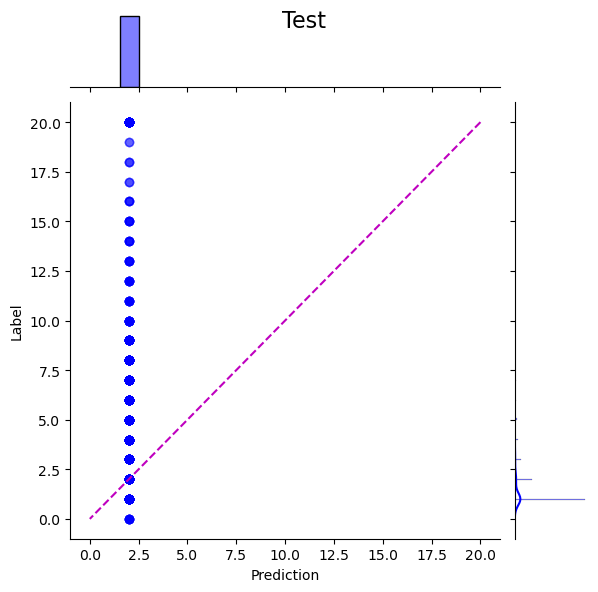

In [ ]:
y_pred = dummy_model.predict(X_test)
PredictionVisualizer.model_performance_sc_plot(y_pred, y_test, "Test");

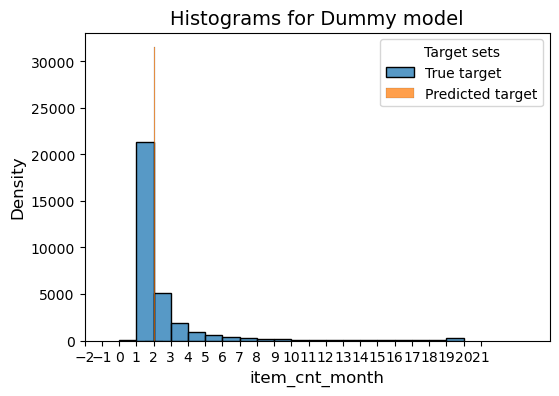

In [ ]:
PredictionVisualizer.plot_predictions_distribution(
    y_test, y_pred, histogram=True, model_name="Dummy model"
)

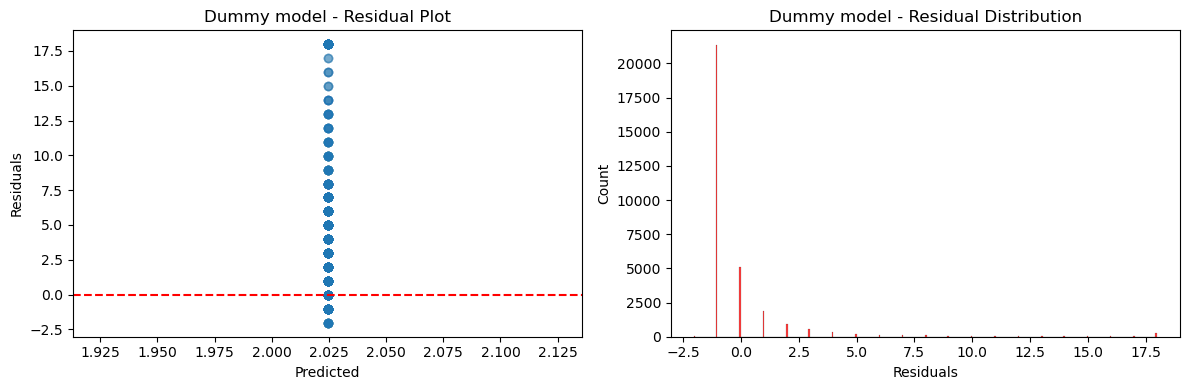

In [ ]:
PredictionVisualizer.plot_residuals(y_test, y_pred, model_name="Dummy model")

### This is obviously a weak model and most of the residuals didn't get into the bar containing zero on the barplot

# **Linear regression**

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [30]:
lr = LinearRegression()
lasso = Lasso(alpha=0.08)
ridge = Ridge(alpha=2)
ModelTrainer.train_model(X, y, lr, apply_scaling=True, print_splits_scores=False)
ModelTrainer.train_model(X, y, lasso, apply_scaling=True, print_splits_scores=False)
ModelTrainer.train_model(X, y, ridge, apply_scaling=True, print_splits_scores=False)

Average RMSE: 1.84
Average RMSE: 1.86
Average RMSE: 1.84


In [31]:
y_pred = lr.predict(X_test_scaled)
y_pred_lasso = lasso.predict(X_test_scaled)
y_pred_ridge = ridge.predict(X_test_scaled)
y_pred = y_pred.clip(0, 20)
y_pred_lasso = y_pred_lasso.clip(0, 20)
y_pred_ridge = y_pred_ridge.clip(0, 20)

### Scatter plots

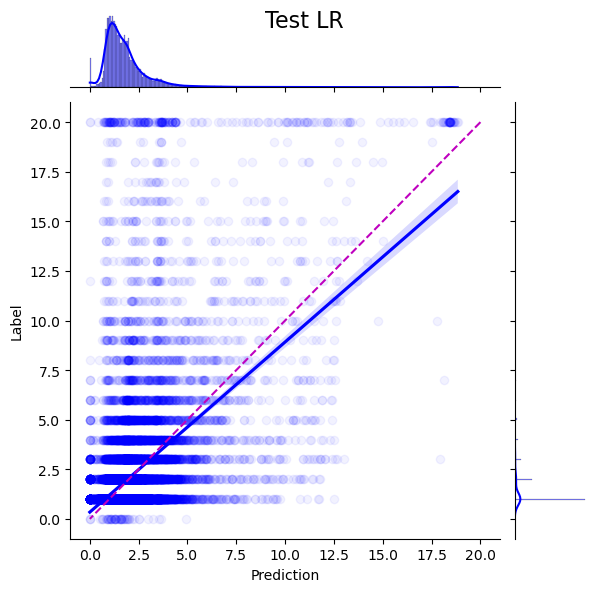

In [ ]:
PredictionVisualizer.model_performance_sc_plot(y_pred, y_test, "Test LR")

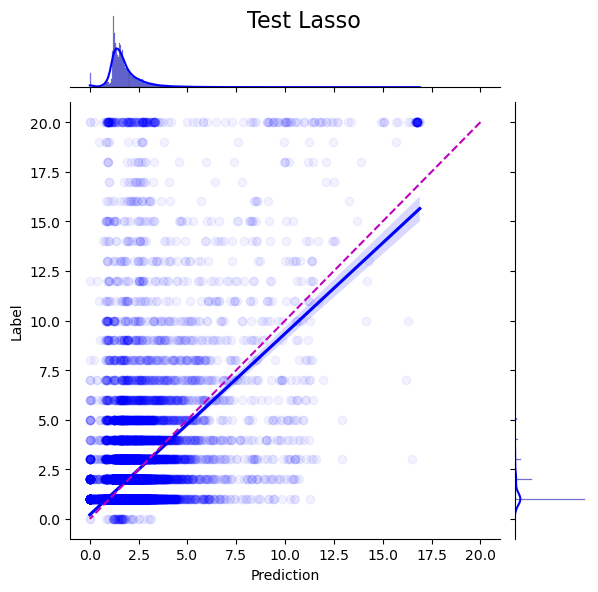

In [ ]:
PredictionVisualizer.model_performance_sc_plot(y_pred_lasso, y_test, "Test Lasso")

### Plot non-zero lasso model coefficients

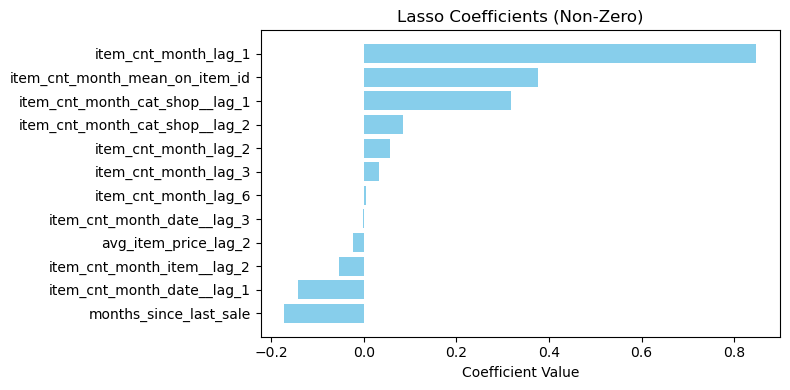

In [ ]:
PredictionVisualizer.plot_coefficients(lasso, X_train)

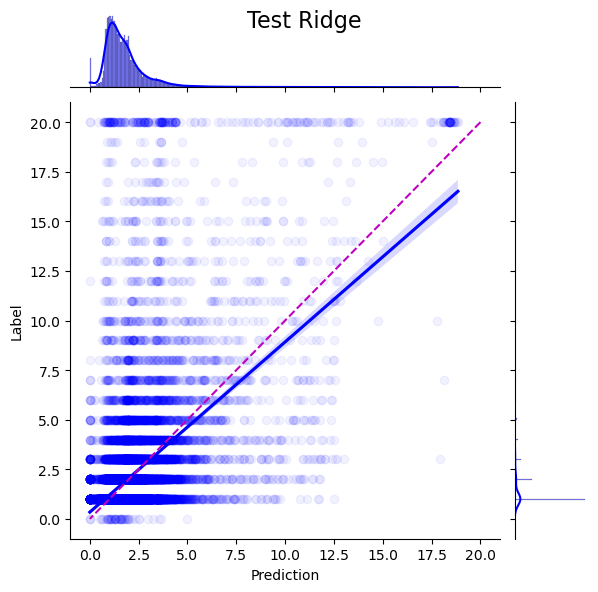

In [ ]:
PredictionVisualizer.model_performance_sc_plot(y_pred_ridge, y_test, "Test Ridge")

In [41]:
print(
    "Difference in linear regression and ridge regression coefficients, in %:\n",
    np.round(((lr.coef_ - ridge.coef_) / ridge.coef_ * 100), 1),
)
print(
    "\nAverage difference in linear regression and ridge regression coefficients, in %:",
    np.mean((lr.coef_ - ridge.coef_) / ridge.coef_ * 100),
)

Difference in linear regression and ridge regression coefficients, in %:
 [  0.2  -6.5   1.8   3.2  -0.4  -0.7   1.6   2.8  -3.2  -0.5   0.5  -0.1
  -0.1  -0.    4.8  -2.   -8.3   0.7   7.2   4.3   1.4 -10.3 -92.4  -1.1
  -0.5   3.8  -0.2  10.7  -9.1  -2.7   0.3   3.8   1.5   0.2   1.6  -2.3]

Average difference in linear regression and ridge regression coefficients, in %: -2.5047019


### Residual plots

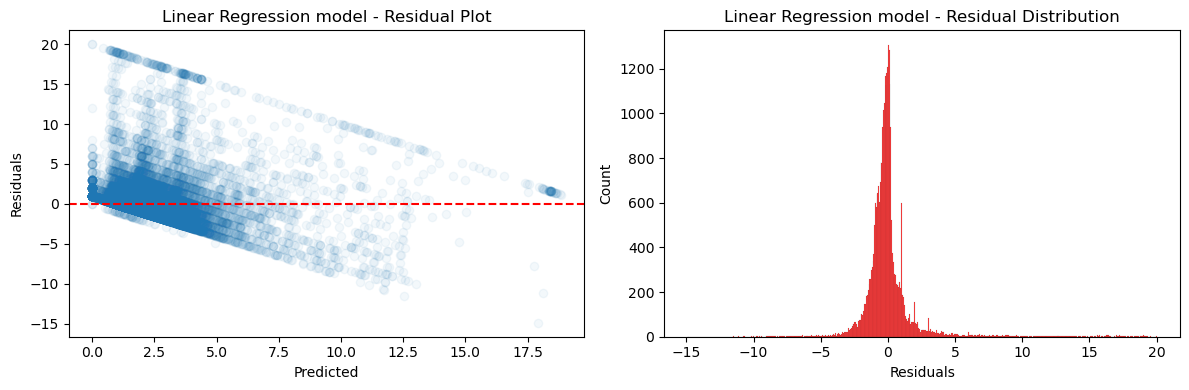

In [ ]:
PredictionVisualizer.plot_residuals(
    y_test, y_pred, model_name="Linear Regression model"
)

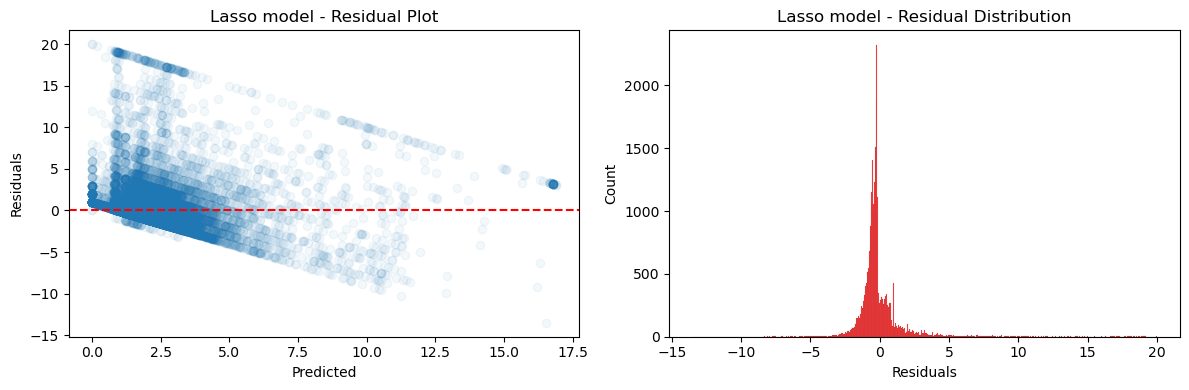

In [ ]:
PredictionVisualizer.plot_residuals(y_test, y_pred_lasso, model_name="Lasso model")

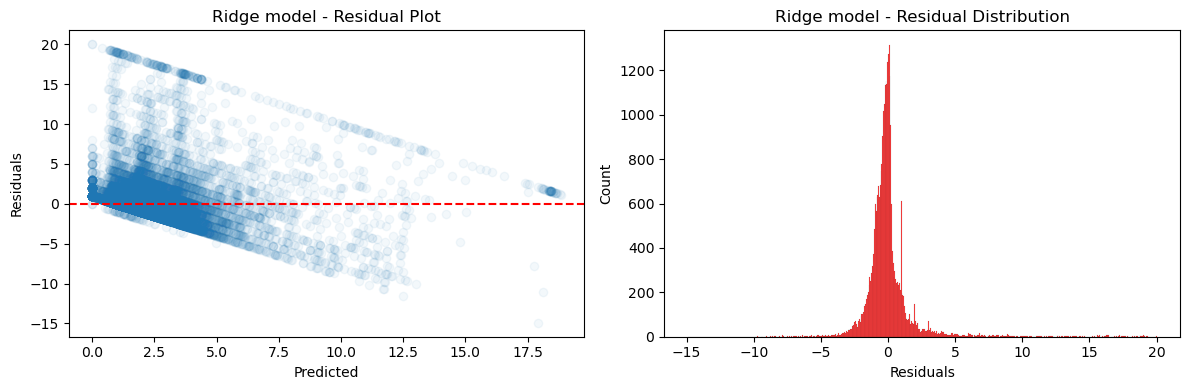

In [ ]:
PredictionVisualizer.plot_residuals(y_test, y_pred_ridge, model_name="Ridge model")

### Predictions distribution

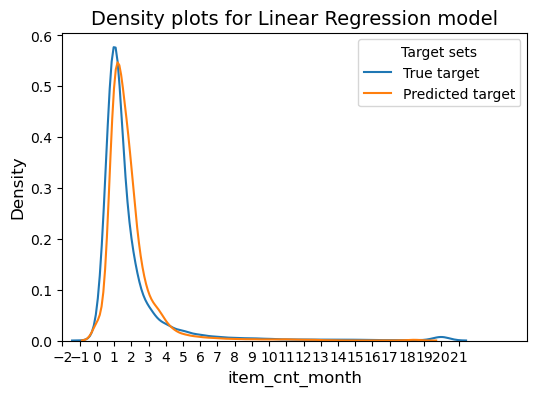

In [ ]:
PredictionVisualizer.plot_predictions_distribution(
    y_test, y_pred, model_name="Linear Regression model"
)

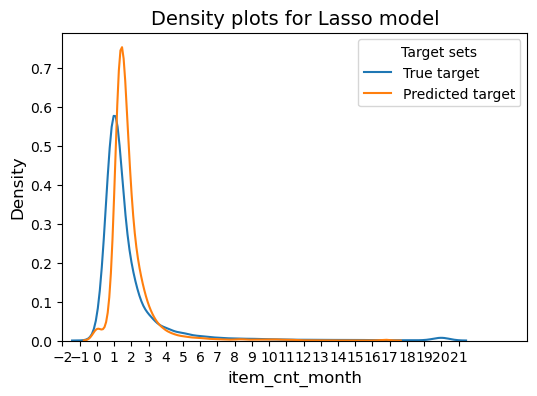

In [ ]:
PredictionVisualizer.plot_predictions_distribution(
    y_test, y_pred_lasso, model_name="Lasso model"
)

### Lasso regression model predicts bigger target values as well as doesn't predict values bigger than ~17

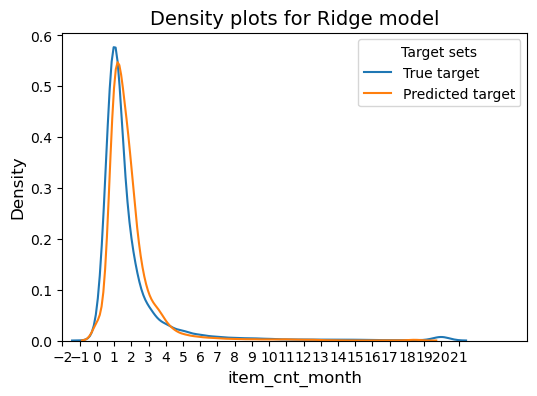

In [ ]:
PredictionVisualizer.plot_predictions_distribution(
    y_test, y_pred_ridge, model_name="Ridge model"
)

### Ridge regression model with $alpha = 2$ gives almost the same results as usual linear regression

# **Support Vector Regression**

In [5]:
from sklearn.svm import LinearSVR, SVR

In [6]:
tscv = TimeSeriesSplit(n_splits=1, method="expanding", train_start=12)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

(889527, 36) (889527,)
(31531, 36) (31531,)


In [7]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

### Use linear kernel first

In [ ]:
linear_svr = LinearSVR(dual="auto", max_iter=1500)
linear_svr.fit(X_train_scaled, y_train)

In [54]:
pickle.dump(linear_svr, open("../models/linear_svr.pkl", "wb"))

In [8]:
linear_svr = pickle.load(open("../models/linear_svr.pkl", "rb"))

In [9]:
y_pred = linear_svr.predict(X_test_scaled)
print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")

RMSE: 2.32771048315735


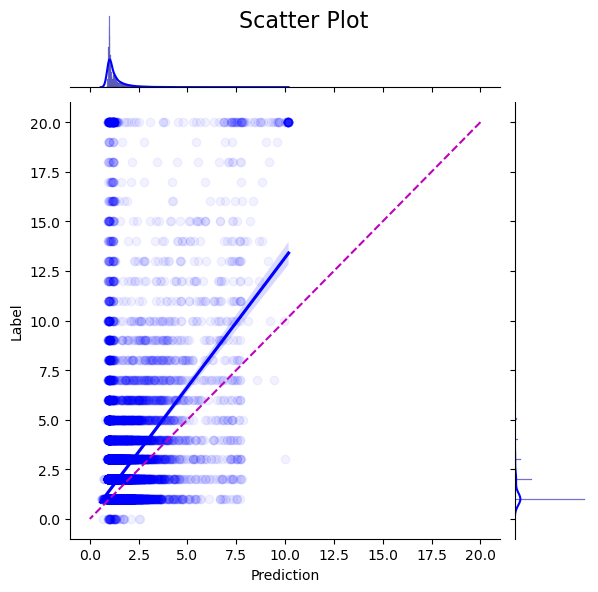

In [10]:
PredictionVisualizer.model_performance_sc_plot(y_pred, y_test)

### As we can see, the untuned linear SVR model only predicts values lying in range [0, 10]. 
### What's more, as the fitted linear regression line shows, the model tends to predict values, that are smaller than real target (the line is above the dashed "y = x" line). In general, it's possible to get better results with linear SVR using hyperparameter tuning methods. I didn't do this as there are more powerful methods and it's better to spend time on tuning them

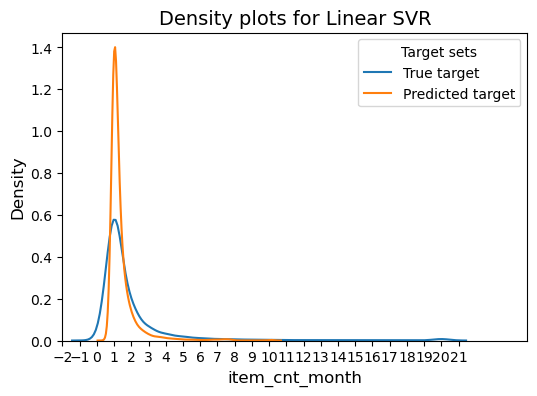

In [11]:
PredictionVisualizer.plot_predictions_distribution(
    y_test, y_pred, model_name="Linear SVR"
)

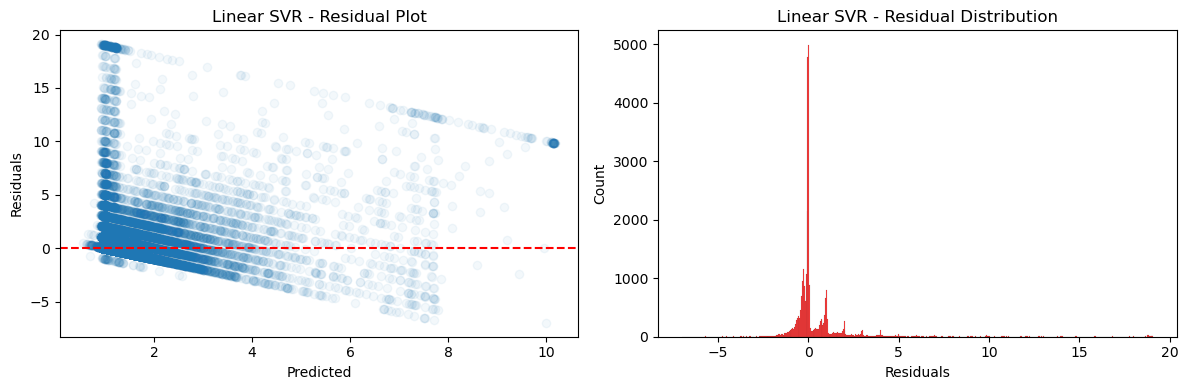

In [25]:
PredictionVisualizer.plot_residuals(y_test, y_pred, model_name="Linear SVR")

SVR required 7 minutes of training with linear kernel and 1 validation split. RBF kernel would require significantly more time, so I'll train it only on part of the dataset

In [26]:
X_train_for_rbf = X_train.copy()

In [27]:
X_train_for_rbf.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_category_id',
       'months_since_last_sale', 'revenue_mean_on_shop_id', 'revenue_lag_1',
       'revenue_lag_2', 'revenue_lag_3', 'revenue_lag_6', 'revenue_lag_12',
       'item_cnt_month_mean_on_item_id', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'item_cnt_month_date__lag_1',
       'item_cnt_month_date__lag_2', 'item_cnt_month_date__lag_3',
       'item_cnt_month_cat__lag_1', 'item_cnt_month_cat__lag_2',
       'item_cnt_month_cat__lag_3', 'item_cnt_month_item__lag_1',
       'item_cnt_month_item__lag_2', 'item_cnt_month_item__lag_3',
       'item_cnt_month_cat_shop__lag_1', 'item_cnt_month_cat_shop__lag_2',
       'item_cnt_month_cat_shop__lag_3', 'days', 'avg_item_price_lag_1',
       'avg_item_price_lag_2', 'avg_item_price_lag_3', 'avg_item_price_lag_4',
       'avg_item_price_lag_5', 'avg_item_price_lag_6'],
      dtype='object')

In [28]:
X_train_for_rbf = X_train_for_rbf[
    [
        "date_block_num",
        "shop_id",
        "item_id",
        "item_category_id",
        "months_since_last_sale",
        "revenue_mean_on_shop_id",
        "revenue_lag_1",
        "item_cnt_month_mean_on_item_id",
        "item_cnt_month_lag_1",
        "item_cnt_month_date__lag_1",
        "item_cnt_month_cat__lag_1",
        "item_cnt_month_item__lag_1",
        "avg_item_price_lag_1",
    ]
]

In [29]:
X_test_for_rbf = X_test[
    [
        "date_block_num",
        "shop_id",
        "item_id",
        "item_category_id",
        "months_since_last_sale",
        "revenue_mean_on_shop_id",
        "revenue_lag_1",
        "item_cnt_month_mean_on_item_id",
        "item_cnt_month_lag_1",
        "item_cnt_month_date__lag_1",
        "item_cnt_month_cat__lag_1",
        "item_cnt_month_item__lag_1",
        "avg_item_price_lag_1",
    ]
]

In [30]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_for_rbf)
X_test_scaled = sc.transform(X_test_for_rbf)

In [66]:
rbf_svr = SVR(kernel="rbf", verbose=True)
rbf_svr.fit(X_train_scaled[-80000:], y_train[-80000:])

[LibSVM]........................................................
*......................*.....*
optimization finished, #iter = 82625
obj = -60659.181465, rho = -5.971420
nSV = 51398, nBSV = 50471


SVR(verbose=True)

In [67]:
pickle.dump(rbf_svr, open("../models/rbf_svr.pkl", "wb"))

In [31]:
rbf_svr = pickle.load(open("../models/rbf_svr.pkl", "rb"))

In [32]:
y_pred = rbf_svr.predict(X_test_scaled)
print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")

RMSE: 2.28302898992989


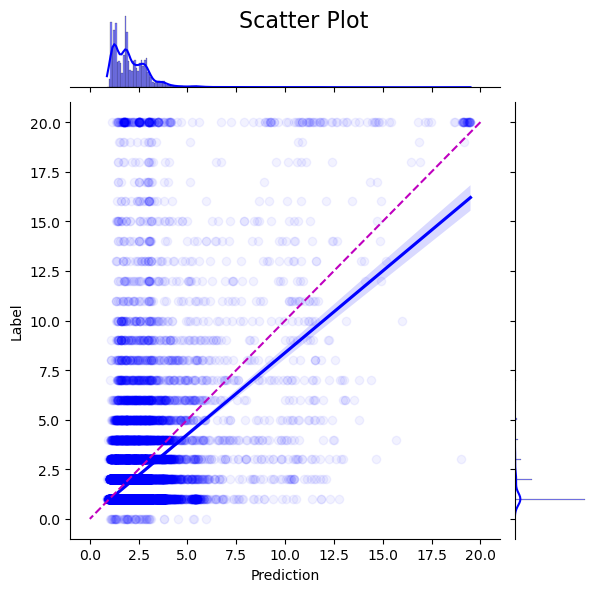

In [33]:
PredictionVisualizer.model_performance_sc_plot(y_pred, y_test)

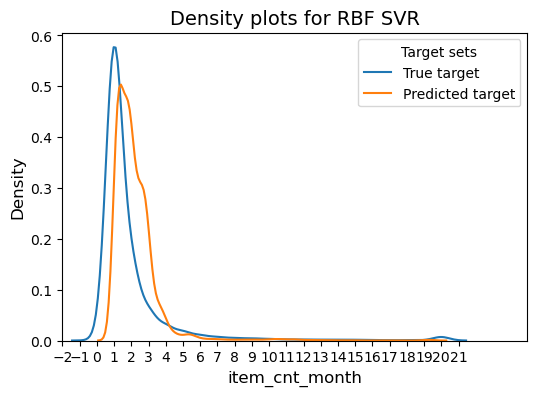

In [34]:
PredictionVisualizer.plot_predictions_distribution(y_test, y_pred, model_name="RBF SVR")

### On the contrary, the rbf kernel predicts values that are bigger than real target

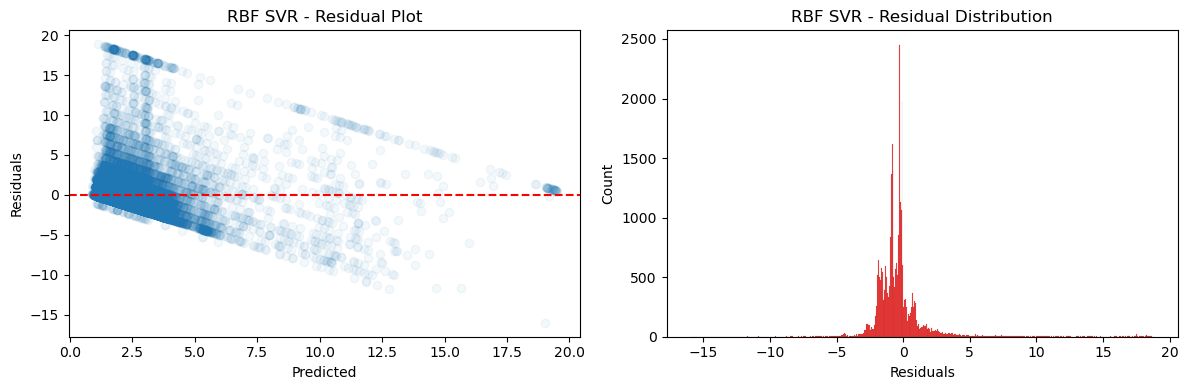

In [ ]:
PredictionVisualizer.plot_residuals(y_test, y_pred, model_name="RBF SVR")

### Unlike the one with linear kernel, rbf SVR predicts values from the right [0, 20] range, though the predictions are still quite bad

# **Random Forest Regressor**

In [45]:
from sklearn.ensemble import RandomForestRegressor

In [74]:
tscv = TimeSeriesSplit(n_splits=1, method="expanding", train_start=12)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

(889527, 36) (889527,)
(31531, 36) (31531,)


In [48]:
rfr = RandomForestRegressor(
    max_depth=17, n_estimators=100, min_samples_leaf=5, random_state=42, n_jobs=-1
)
ModelTrainer.train_model(X, y, rfr, train_start=12, cv_n_splits=1)

1 split RMSE: 1.95

Average RMSE: 1.95


In [53]:
pickle.dump(rfr, open("../models/rfr.pkl", "wb"))

In [75]:
rfr = pickle.load(open("../models/rfr.pkl", "rb"))

In [76]:
y_pred = rfr.predict(X_test)
y_pred = y_pred.clip(0, 20)

/home/alexennk/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


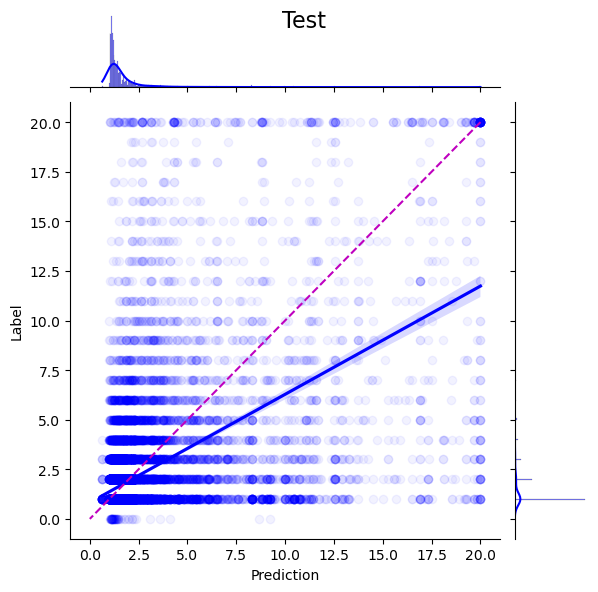

In [ ]:
PredictionVisualizer.model_performance_sc_plot(y_pred, y_test, "Test")

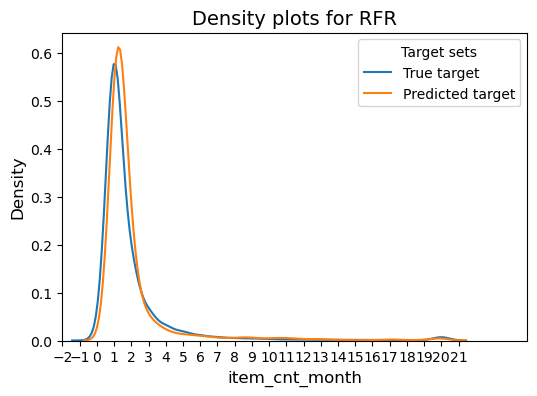

In [ ]:
PredictionVisualizer.plot_predictions_distribution(y_test, y_pred, model_name="RFR")

### The density plots are very close to each other

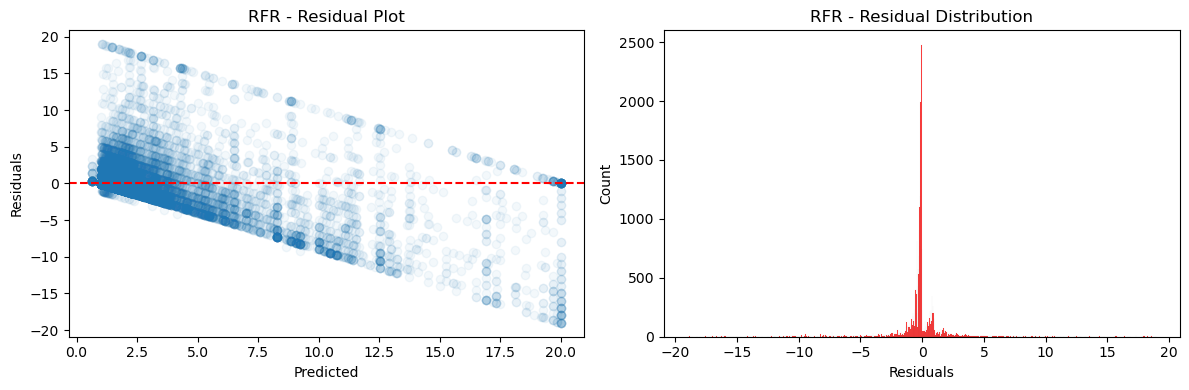

In [ ]:
PredictionVisualizer.plot_residuals(y_test, y_pred, model_name="RFR")

# **CatBoost Regressor**

I've already used XGBoost in the "validate_notebook.ipynb", so now I've chosen the CatBoost for a kind of model diversity

In [35]:
from catboost import CatBoostRegressor

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [36]:
X[["shop_id", "item_id", "item_category_id"]] = X[
    ["shop_id", "item_id", "item_category_id"]
].astype(np.int32)

In [37]:
tscv = TimeSeriesSplit(n_splits=1, method="expanding", train_start=12)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

(889527, 36) (889527,)
(31531, 36) (31531,)


In [86]:
catboost_model = CatBoostRegressor(
    iterations=1000,
    verbose=10,
    depth=8,
    eta=0.2,
    eval_metric="RMSE",
    early_stopping_rounds=50,
    cat_features=["shop_id", "item_id", "item_category_id"],
)

In [87]:
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 2.3318175	test: 2.3876464	best: 2.3876464 (0)	total: 312ms	remaining: 5m 11s
10:	learn: 1.6953495	test: 2.0208431	best: 2.0208431 (10)	total: 3.69s	remaining: 5m 32s
20:	learn: 1.6115438	test: 2.0148197	best: 2.0086917 (19)	total: 7.43s	remaining: 5m 46s
30:	learn: 1.5618704	test: 2.0102121	best: 2.0086917 (19)	total: 11.1s	remaining: 5m 47s
40:	learn: 1.5253228	test: 2.0042141	best: 2.0042141 (40)	total: 14.8s	remaining: 5m 47s
50:	learn: 1.4993786	test: 1.9861582	best: 1.9861582 (50)	total: 18.4s	remaining: 5m 42s
60:	learn: 1.4849327	test: 1.9767241	best: 1.9758350 (58)	total: 21.6s	remaining: 5m 33s
70:	learn: 1.4687624	test: 1.9729782	best: 1.9729782 (70)	total: 25.1s	remaining: 5m 28s
80:	learn: 1.4444081	test: 1.9653251	best: 1.9653251 (80)	total: 28.9s	remaining: 5m 27s
90:	learn: 1.4340121	test: 1.9661171	best: 1.9647170 (81)	total: 31.6s	remaining: 5m 15s
100:	learn: 1.4218914	test: 1.9682457	best: 1.9647170 (81)	total: 35.2s	remaining: 5m 13s
110:	learn: 1.4121062	

In [88]:
catboost_model.save_model("../models/catboost_model_untuned.cbm")

In [38]:
catboost_model = CatBoostRegressor()
catboost_model.load_model("../models/catboost_model_untuned.cbm")

In [39]:
y_pred = catboost_model.predict(X_test)
y_pred = y_pred.clip(0, 20)

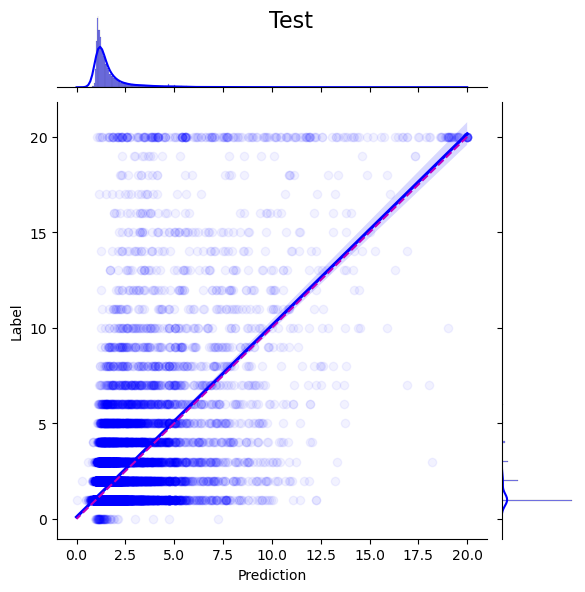

In [40]:
PredictionVisualizer.model_performance_sc_plot(y_pred, y_test, "Test")

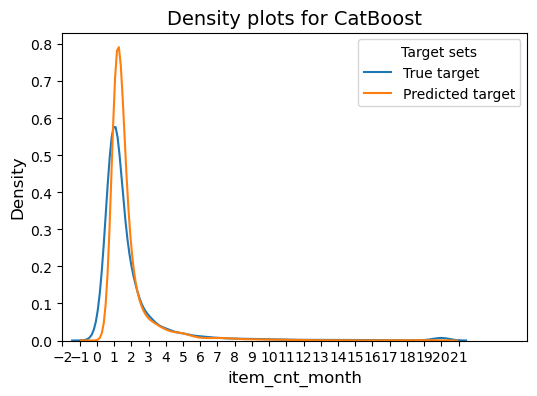

In [41]:
PredictionVisualizer.plot_predictions_distribution(
    y_test, y_pred, model_name="CatBoost"
)

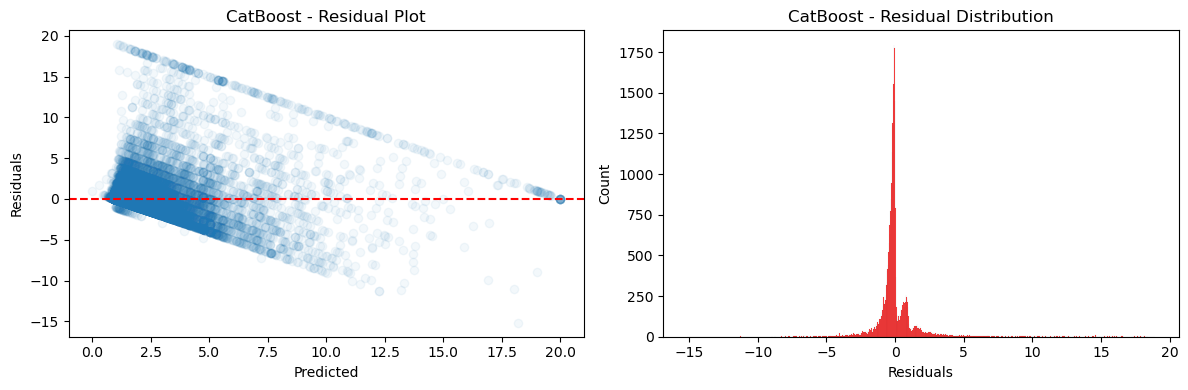

In [42]:
PredictionVisualizer.plot_residuals(y_test, y_pred, model_name="CatBoost")

### Comparing Random Forest and CatBoost, the latter gives less spread predictions as well as it almost doesn't predict high sales (like 15 - 20) for little target values (like 0 - 2), which we saw on the rfr predictions plots

In [96]:
eval_history = catboost_model.get_evals_result()

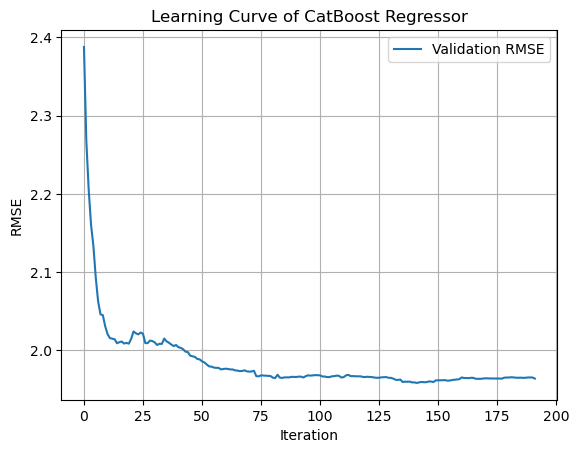

In [ ]:
plt.plot(eval_history["validation"]["RMSE"], label="Validation RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Learning Curve of CatBoost Regressor")
plt.legend()
plt.grid()
plt.show()

### This instability region of the learning curve may indicate high learning rate

# **Hyperopt for Random Forest Regressor**

In [47]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

tscv = TimeSeriesSplit(n_splits=1, method="expanding", train_start=12)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

(889527, 36) (889527,)
(31531, 36) (31531,)


In [ ]:
def objective(params):
    """
    Objective function for RandomForestRegressor hyperparameter tuning.
    """

    model = RandomForestRegressor(
        n_estimators=int(params["n_estimators"]),
        max_depth=int(params["max_depth"]),
        min_samples_split=int(params["min_samples_split"]),
        min_samples_leaf=int(params["min_samples_leaf"]),
        max_features=params["max_features"],
        random_state=42,
        n_jobs=-1,
    )

    neg_rmse = cross_val_score(
        model, X, y, cv=tscv, scoring="neg_root_mean_squared_error"
    ).mean()

    return {"loss": -neg_rmse, "status": STATUS_OK}


space = {
    "n_estimators": hp.quniform("n_estimators", 50, 300, 10),
    "max_depth": hp.quniform("max_depth", 8, 20, 1),
    "min_samples_split": hp.quniform("min_samples_split", 2, 20, 1),
    "min_samples_leaf": hp.quniform("min_samples_leaf", 1, 10, 1),
    "max_features": hp.choice("max_features", ["sqrt", "log2", None]),
}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Best hyperparameters:", best)

100%|██████████| 50/50 [2:10:59<00:00, 157.19s/trial, best loss: 1.8839136138730572]  
Best hyperparameters: {'max_depth': 18.0, 'max_features': 0, 'min_samples_leaf': 7.0, 'min_samples_split': 8.0, 'n_estimators': 200.0}


In [43]:
best = {
    "max_depth": 18.0,
    "max_features": 0,
    "min_samples_leaf": 7.0,
    "min_samples_split": 8.0,
    "n_estimators": 200.0,
}

### Best hyperparameters: {'max_depth': 18.0, 'max_features': 0, 'min_samples_leaf': 7.0, 'min_samples_split': 8.0, 'n_estimators': 200.0}

### Train a rfr on the whole dataset:

In [49]:
tscv = TimeSeriesSplit(n_splits=1, method="expanding", train_start=0)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

(1577193, 36) (1577193,)
(31531, 36) (31531,)


In [50]:
best_model = RandomForestRegressor(
    n_estimators=int(best["n_estimators"]),
    max_depth=int(best["max_depth"]),
    min_samples_split=int(best["min_samples_split"]),
    min_samples_leaf=int(best["min_samples_leaf"]),
    max_features=["sqrt", "log2", None][best["max_features"]],
    random_state=42,
    n_jobs=-1,
)
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=18, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=8, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [51]:
y_pred = best_model.predict(X_test)
rmse = np.sqrt(((y_pred - y_test) ** 2).mean())
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 1.8982


### Plot predictions

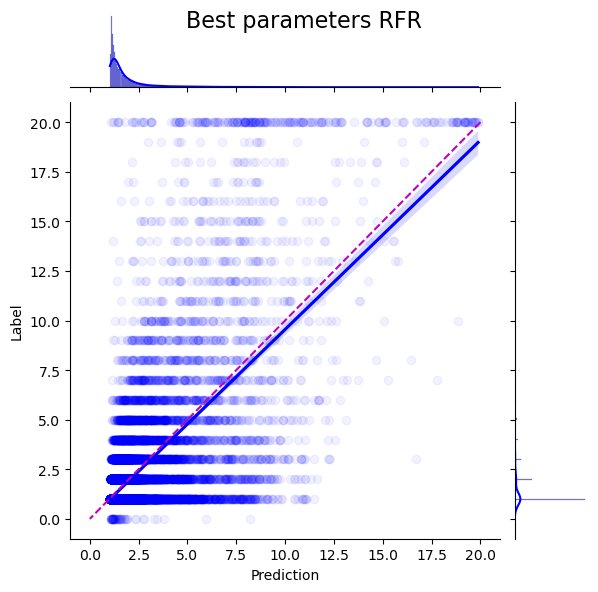

In [52]:
PredictionVisualizer.model_performance_sc_plot(y_pred, y_test, "Best parameters RFR")

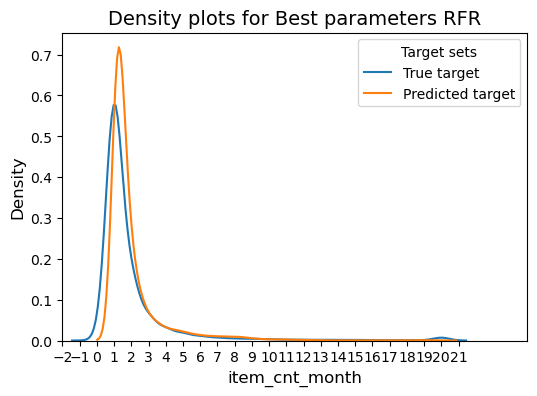

In [53]:
PredictionVisualizer.plot_predictions_distribution(
    y_test, y_pred, model_name="Best parameters RFR"
)

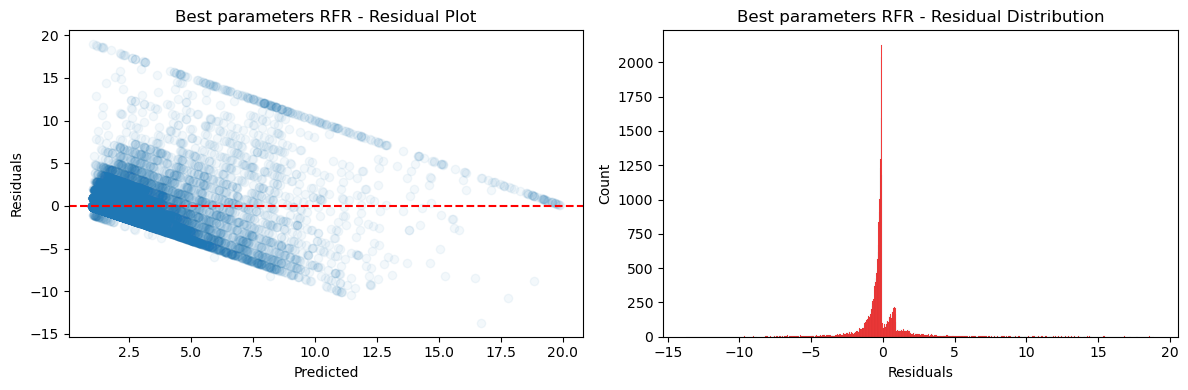

In [54]:
PredictionVisualizer.plot_residuals(y_test, y_pred, model_name="Best parameters RFR")

### Now the residuals and predictions plots look similar to the CatBoost ones

In [103]:
pickle.dump(best_model, open("../models/best_rfr.pkl", "wb"))

### Plot built-in feature importances

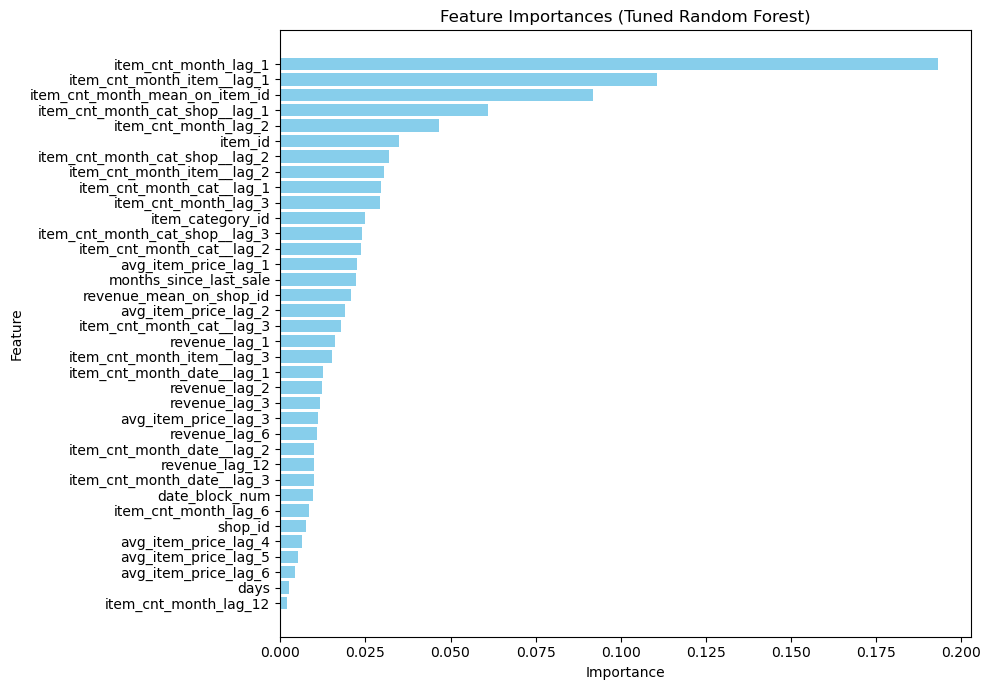

In [ ]:
PredictionVisualizer.plot_feature_importances(best_model, X_train)

# **Boruta**

In [108]:
from boruta import BorutaPy

tscv = TimeSeriesSplit(n_splits=1, method="expanding", train_start=12)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

(889527, 36) (889527,)
(31531, 36) (31531,)


In [ ]:
# To avoid the error calling BorutaPy.fit()
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

rf = RandomForestRegressor(
    max_depth=18,
    max_features="sqrt",
    min_samples_leaf=7,
    min_samples_split=8,
    n_estimators=200,
    n_jobs=-1,
    random_state=42,
)

boruta_selector = BorutaPy(estimator=rf, random_state=42, max_iter=50, verbose=2)

boruta_selector.fit(X_train[-200000:].values, y_train[-200000:].values)

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	36
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	34
Tentative: 	2
Rejected: 	0
Iteration: 	9 / 50
Confirmed: 	34
Tentative: 	0
Rejected: 	2


BorutaPy finished running.

Iteration: 	10 / 50
Confirmed: 	34
Tentative: 	0
Rejected: 	2


BorutaPy(estimator=RandomForestRegressor(max_depth=18, max_features='sqrt',
                                         min_samples_leaf=7,
                                         min_samples_split=8, n_estimators=1000,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7507623ACB40),
         max_iter=50, random_state=RandomState(MT19937) at 0x7507623ACB40,
         verbose=2)

In [13]:
# Get the selected features
selected_features = X_train.columns[boruta_selector.support_].tolist()

In [ ]:
# a cell not to lose the selected features accidentally
selected_features = [
    "date_block_num",
    "shop_id",
    "item_id",
    "item_category_id",
    "revenue_mean_on_shop_id",
    "revenue_lag_1",
    "revenue_lag_2",
    "revenue_lag_3",
    "revenue_lag_6",
    "revenue_lag_12",
    "item_cnt_month_mean_on_item_id",
    "item_cnt_month_lag_1",
    "item_cnt_month_lag_2",
    "item_cnt_month_lag_3",
    "item_cnt_month_lag_6",
    "item_cnt_month_lag_12",
    "item_cnt_month_date__lag_1",
    "item_cnt_month_date__lag_2",
    "item_cnt_month_date__lag_3",
    "item_cnt_month_cat__lag_1",
    "item_cnt_month_cat__lag_2",
    "item_cnt_month_cat__lag_3",
    "item_cnt_month_item__lag_1",
    "item_cnt_month_item__lag_2",
    "item_cnt_month_item__lag_3",
    "item_cnt_month_cat_shop__lag_1",
    "item_cnt_month_cat_shop__lag_2",
    "item_cnt_month_cat_shop__lag_3",
    "avg_item_price_lag_1",
    "avg_item_price_lag_2",
    "avg_item_price_lag_3",
    "avg_item_price_lag_4",
    "avg_item_price_lag_5",
    "avg_item_price_lag_6",
]

In [110]:
len(selected_features)

34

In [16]:
all_features_ranked = list(zip(X_train.columns, boruta_selector.ranking_))

print("Selected Features:", selected_features)
print("\nFeature Rankings:")
for feature, rank in sorted(all_features_ranked, key=lambda x: x[1]):
    print(f"{feature}: Rank {rank}")

Selected Features: ['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'revenue_mean_on_shop_id', 'revenue_lag_1', 'revenue_lag_2', 'revenue_lag_3', 'revenue_lag_6', 'revenue_lag_12', 'item_cnt_month_mean_on_item_id', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12', 'item_cnt_month_date__lag_1', 'item_cnt_month_date__lag_2', 'item_cnt_month_date__lag_3', 'item_cnt_month_cat__lag_1', 'item_cnt_month_cat__lag_2', 'item_cnt_month_cat__lag_3', 'item_cnt_month_item__lag_1', 'item_cnt_month_item__lag_2', 'item_cnt_month_item__lag_3', 'item_cnt_month_cat_shop__lag_1', 'item_cnt_month_cat_shop__lag_2', 'item_cnt_month_cat_shop__lag_3', 'avg_item_price_lag_1', 'avg_item_price_lag_2', 'avg_item_price_lag_3', 'avg_item_price_lag_4', 'avg_item_price_lag_5', 'avg_item_price_lag_6']

Feature Rankings:
date_block_num: Rank 1
shop_id: Rank 1
item_id: Rank 1
item_category_id: Rank 1
revenue_mean_on_shop_id: Rank 1
revenue_

### The boruta algorithm selected 34 of 36 features. Taking into account the amount of time it requires to work, boruta is not the best choice for this particular task and I would prefer to analyze feature importances with SHAP (below)

### Train a rfr with a new set of features

In [ ]:
X_train_boruta = boruta_selector.transform(X_train.values)
X_test_boruta = boruta_selector.transform(X_test.values)

In [ ]:
final_rf = RandomForestRegressor(
    max_depth=18,
    max_features="sqrt",
    min_samples_leaf=7,
    min_samples_split=8,
    n_estimators=200,
    n_jobs=-1,
    random_state=42,
)
final_rf.fit(X_train_boruta, y_train)

RandomForestRegressor(max_depth=18, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=8, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [ ]:
y_pred = final_rf.predict(X_test_boruta)
rmse = np.sqrt(((y_pred - y_test) ** 2).mean())
print(f"Validation RMSE (using selected features): {rmse:.4f}")

Validation RMSE (using selected features): 1.8959


# **SHAP**

In [111]:
rfr = pickle.load(open("../models/best_rfr.pkl", "rb"))

In [112]:
import shap

explainer = shap.Explainer(rfr)

In [113]:
X_test_sample = X_test.sample(200, random_state=42)
y_test_sample = y_test[X_test_sample.index]

In [114]:
shap_values = explainer(X_test_sample)

#### Plot shap_values distribution

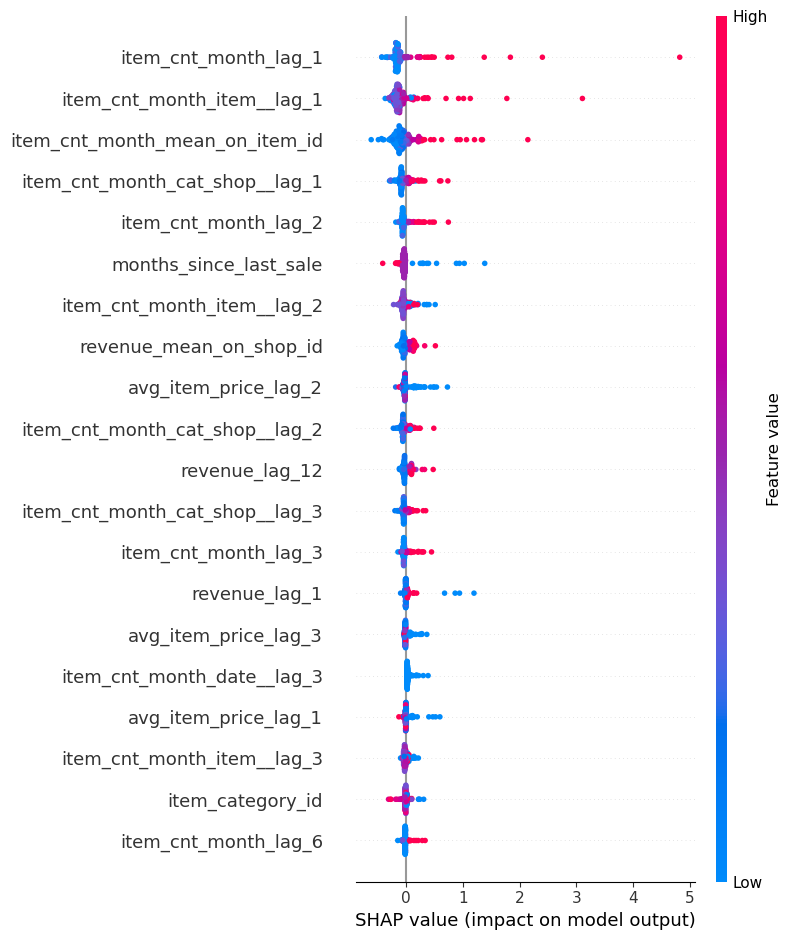

In [115]:
fig, ax = plt.subplots()

shap.summary_plot(shap_values, X_test_sample)
fig.set_size_inches(4, 7)
ax.set_title("SHAP summary plot")
ax.set_xlabel("Mean SHAP values")
ax.set_ylabel("Features");

### Calculate and plot feature importances

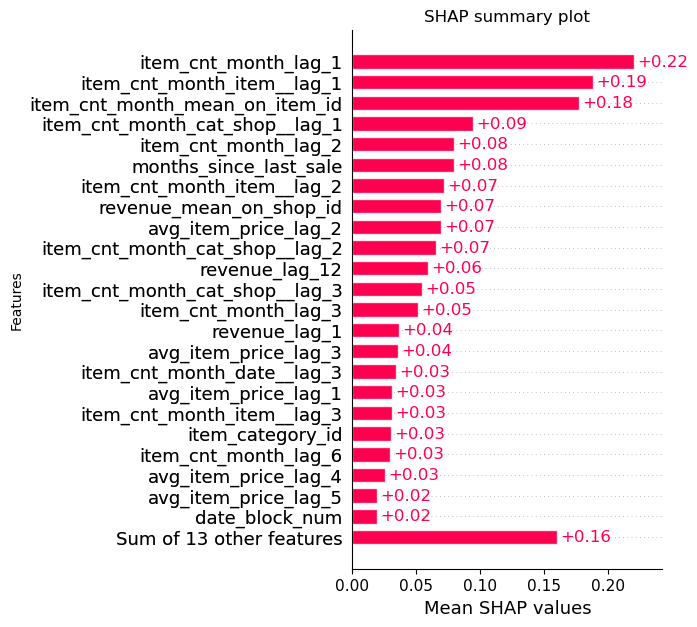

In [116]:
fig, ax = plt.subplots()

shap.plots.bar(shap_values, show=False, max_display=24)
fig.set_size_inches(4, 7)
ax.set_title("SHAP summary plot")
ax.set_xlabel("Mean SHAP values")
ax.set_ylabel("Features");

# **Plot shap values for an individual prediction**

### A relatively good prediction first

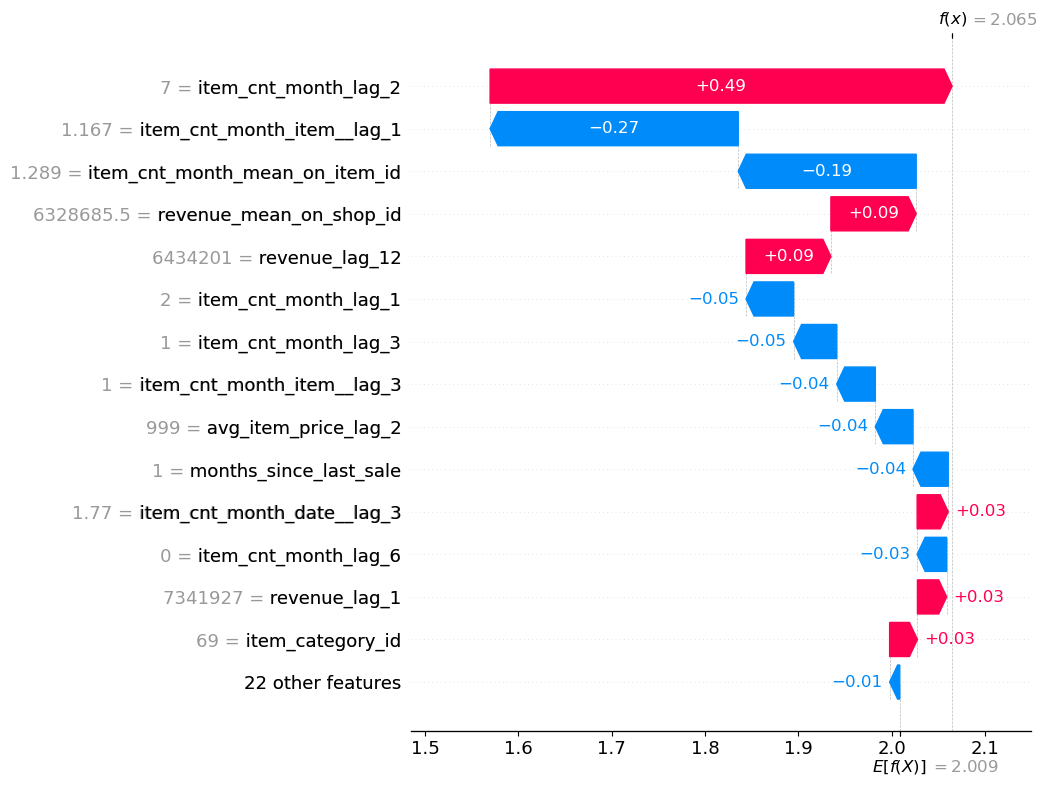

In [133]:
shap.plots.waterfall(shap_values[41], max_display=15)

In [136]:
print("Real value:", y_test_sample.iloc[41])

Real value: 2.0


### A worse prediction

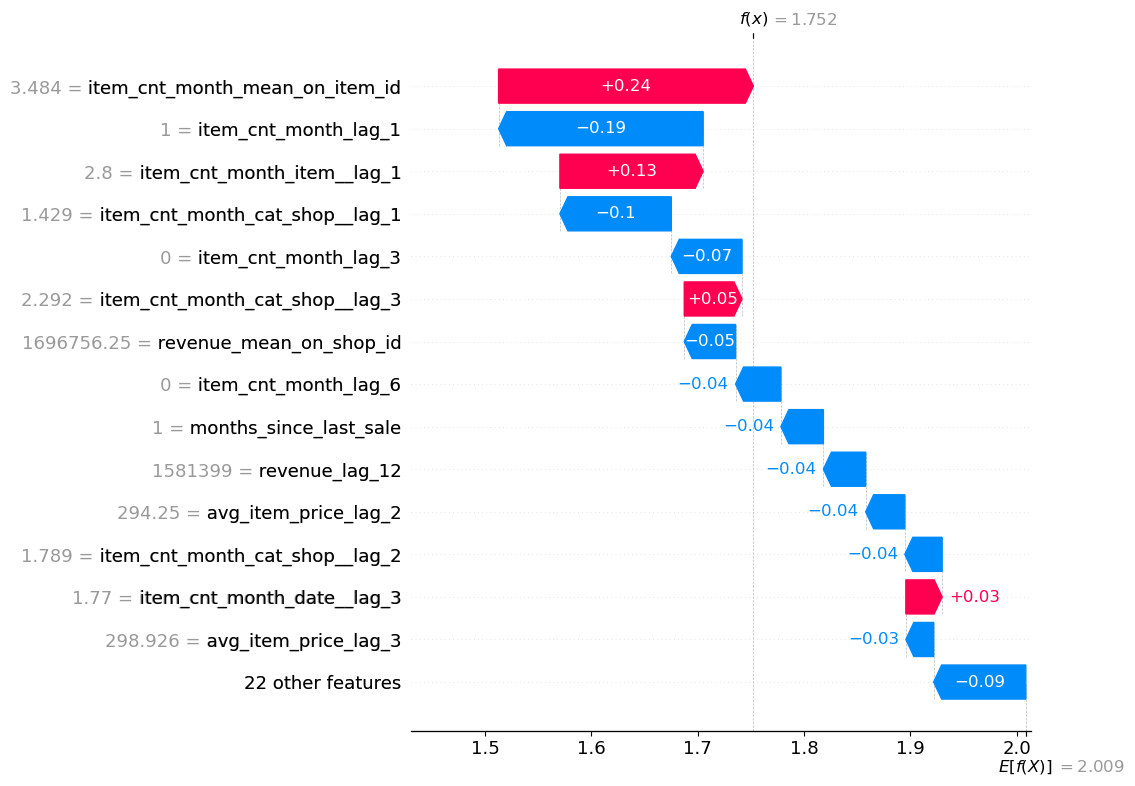

In [146]:
shap.plots.waterfall(shap_values[15], max_display=15)

In [147]:
print("Real value:", y_test_sample.iloc[15])

Real value: 1.0


### The overall sales statistics for that particular item (the **item_cnt_month_mean_on_item_id** feature) is perhaps not representative for the sales in that particular shop

### Train and evaluate a rfr with important features

In [56]:
X.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_category_id',
       'months_since_last_sale', 'revenue_mean_on_shop_id', 'revenue_lag_1',
       'revenue_lag_2', 'revenue_lag_3', 'revenue_lag_6', 'revenue_lag_12',
       'item_cnt_month_mean_on_item_id', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'item_cnt_month_date__lag_1',
       'item_cnt_month_date__lag_2', 'item_cnt_month_date__lag_3',
       'item_cnt_month_cat__lag_1', 'item_cnt_month_cat__lag_2',
       'item_cnt_month_cat__lag_3', 'item_cnt_month_item__lag_1',
       'item_cnt_month_item__lag_2', 'item_cnt_month_item__lag_3',
       'item_cnt_month_cat_shop__lag_1', 'item_cnt_month_cat_shop__lag_2',
       'item_cnt_month_cat_shop__lag_3', 'days', 'avg_item_price_lag_1',
       'avg_item_price_lag_2', 'avg_item_price_lag_3', 'avg_item_price_lag_4',
       'avg_item_price_lag_5', 'avg_item_price_lag_6'],
      dtype='object')

In [57]:
X_small = X[
    [
        "date_block_num",
        "item_category_id",
        "months_since_last_sale",
        "revenue_mean_on_shop_id",
        "revenue_lag_1",
        "revenue_lag_2",
        "item_cnt_month_mean_on_item_id",
        "item_cnt_month_lag_1",
        "item_cnt_month_lag_2",
        "item_cnt_month_lag_3",
        "item_cnt_month_lag_6",
        "item_cnt_month_item__lag_1",
        "item_cnt_month_item__lag_2",
        "item_cnt_month_item__lag_3",
        "avg_item_price_lag_1",
        "avg_item_price_lag_2",
        "avg_item_price_lag_3",
        "avg_item_price_lag_4",
    ]
]

In [61]:
tscv = TimeSeriesSplit(n_splits=1, method="expanding")

for train_idx, test_idx in tscv.split(X_small):
    X_train, X_test = X_small[train_idx], X_small[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

(1577193, 18) (1577193,)
(31531, 18) (31531,)


In [62]:
rfr_small = RandomForestRegressor(
    max_depth=18,
    max_features="sqrt",
    min_samples_leaf=7,
    min_samples_split=8,
    n_estimators=200,
    n_jobs=-1,
    random_state=42,
)
rfr_small.fit(X_train, y_train)

RandomForestRegressor(max_depth=18, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=8, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [63]:
y_pred = rfr_small.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Validation RMSE (using selected features): {rmse:.4f}")

Validation RMSE (using selected features): 1.9181


# **Conclusion:**

- **trained and evaluated**:
    - Linear Regression (no regularization, Lasso and Ridge variants) 
    - linear and rbf Support Vector Regression
    - Random Forest
    - CatBoost Gradient Boosting
- analyzed predictions and residuals for each model as well as plotted feature importances for some of them
- used **TPE** algorithm and **Hyperopt** library for Random Forest hyperparameter tuning
- performed Boruta feature selection with a Random Forest model and got 34 of 36 features selected
- used **SHAP** for calculating features importances and analyzing individual Random Forest predictions

### In general, more complex models tend to predict bigger values on the average. Linear models have lower standard deviation of predictions, while the RFR and CatBoost models do predict similar to each other